

# Analysis of Auto-Sklearn and CLS-Luigi Results for Binary Classification Problems

## Overview <a id=ov>
1. [Dataset Information](#ds_info)<br>
2. [Effeciency](#eff)<br>
3. [Accuracy Scores](#scores)<br>
4. [Score Distribution](#scores_dist)<br>



In [1]:

ds_in_autosklearn = [
        'spambase',
        'pc4',
        'wilt',
        'qsar-biodeg',
        'mozilla4',
        'steel-plates-fault',
        'ozone-level-8hr',
        'eeg-eye-state',
        'madelon',
    ]

dataset_names = [
        'spambase', # exists in autosklearn
        'sylvine',
        'bank-marketing',
        'phoneme',
        'kc1',  # exists in autosklearn
        'pc4', # exists in autosklearn
        'wilt', # exists in autosklearn
        'qsar-biodeg', # exists in autosklearn
        'mozilla4', # exists in autosklearn
        'steel-plates-fault', # exists in autosklearn
        'ozone-level-8hr', # exists in autosklearn
        'eeg-eye-state', # exists in autosklearn
        'madelon',
        'numerai28.6',
        'higgs',
    ]
    

ds_ids = [

        9967,  # steel-plates-fault
        9957,  # qsar-biodeg
        9952,  # phoneme
        9978,  # ozone-level-8hr
        146820,  # wilt
        3899,  # mozilla4
        9983,  # eeg-eye-state
        359962,  # kc1 classification
        359958,  # pc4 classification
        361066,  # bank-marketing classification
        359972,  # sylvin classification
        9976,  # Madelon

        167120,  # numerai28.6
        146606,  # higgs
        43,  #spambase
    ]


components = {
    "feature_preprocessor": [
        "SKLFastICA",
        "SKLFeatureAgglomeration",
        "SKLKernelPCA",
        "SKLNystroem",
        "SKLPCA",
        "SKLPolynomialFeatures",
        "SKLRandomTreesEmbedding",
        "SKLRBFSampler",
        "SKLSelectFromExtraTrees",
        "SKLSelectFromLinearSVC",
        "SKLSelectPercentile",
        "SKLSelectRates"
    ],
    "scaler":[
        "SKLMinMaxScaler",
        "SKLNormalizer",
        "SKLPowerTransformer",
        "SKLQuantileTransformer",
        "SKLRobustScaler",
        "SKLStandardScaler"
    ],
    "imputer": [
        "SKLSimpleImpute"
    ]
}

clf_short_names = {
    'RandomForestOnly': "RFOnly",

    'SKLRandomForest': "RF",
    'SKLExtraTrees':"EXT",
    'SKLDecisionTree':"DT",
    'SKLKNearestNeighbors':"KNN",

    'SKLGradientBoosting':"GB",
    'SKLSGD': "SGD",
    'SKLAdaBoost':"ADA",

    'SKLLinearSVC':"LSVC",
    'SKLKernelSVC':"KSVC",
    
    'SKLLinearDiscriminantAnalysis':"LDA",
    'SKLQuadraticDiscriminantAnalysis':"QDA",

    'SKLPassiveAggressive':"PA",
    
    'SKLGaussianNaiveBayes':"GNB",
    'SKLMultinomialNB':"MNB",
    'SKLBernoulliNB':"BNB",
}


In [2]:
import pandas as pd
from openml import tasks
import warnings
import json 
from os.path import join as pjoin
from os import listdir
from statistics import median, geometric_mean
import pickle
import autosklearn.classification
import seaborn as sns


warnings.filterwarnings("ignore")

### 1. Dataset Information <a id=ds_info>
[back to overview](#ov)

In [3]:


def get_ds_info(ds_id):
    task = tasks.get_task(ds_id)
    
    x, _ = task.get_X_and_y(dataset_format='dataframe')    
    
    n_features = x.shape[1]
    n_instances = x.shape[0]
    ds_name = task.get_dataset().name
    url = task.openml_url
    
    return ds_name, n_features, n_instances, url


def make_datasets_df(ds_ids, in_autosklearn_list):
    data  ={
        'ds_name':[],
        'ds_id':[],
        'n_instances':[],
        'n_features':[],
        'in_autosklearn':[]
    }
    
    for ds_id in ds_ids:
        ds_name, n_features, n_instances, url = get_ds_info(ds_id)
        data['ds_id'].append( "\href" + "{" + url + "}" + "{" + str(ds_id) + "}" )
        data['ds_name'].append(ds_name)
        data['n_features'].append(n_features)
        data['n_instances'].append(n_instances)
        data['in_autosklearn'].append("X" if ds_name in in_autosklearn_list else "-")
        
        
    df = pd.DataFrame(data)
    
    df = df.rename(columns={
        'ds_id':'OpenML-ID',
        'ds_name':'Name',
        'n_features':'#Features',
        'n_instances':'#Instances', 
        'in_autosklearn':'In AutoSklearn Metadata?'})
    
    return df 


dataset_info = make_datasets_df(ds_ids, ds_in_autosklearn)

In [4]:
dataset_info.sort_values(by=['#Instances'], ascending=False, inplace=True)

dataset_info

,Name,OpenML-ID,#Instances,#Features,In AutoSklearn Metadata?
13,higgs,\href{https://www.openml.org/t/146606}{146606},98050,28,-
12,numerai28.6,\href{https://www.openml.org/t/167120}{167120},96320,21,-
5,mozilla4,\href{https://www.openml.org/t/3899}{3899},15545,5,X
6,eeg-eye-state,\href{https://www.openml.org/t/9983}{9983},14980,14,X
9,bank-marketing,\href{https://www.openml.org/t/361066}{361066},10578,7,-
2,phoneme,\href{https://www.openml.org/t/9952}{9952},5404,5,-
10,sylvine,\href{https://www.openml.org/t/359972}{359972},5124,20,-
4,wilt,\href{https://www.openml.org/t/146820}{146820},4839,5,X
14,spambase,\href{https://www.openml.org/t/43}{43},4601,57,X
11,madelon,\href{https://www.openml.org/t/9976}{9976},2600,500,X


In [5]:
def format_lattex_backslash(s):
    return s.replace('\\textbackslash', '\\')



print(dataset_info.to_latex(index=False, escape=False, formatters={"OpenML-ID": format_lattex_backslash}))

\begin{tabular}{llrrl}
\toprule
Name & OpenML-ID & #Instances & #Features & In AutoSklearn Metadata? \\
\midrule
higgs & \href{https://www.openml.org/t/146606}{146606} & 98050 & 28 & - \\
numerai28.6 & \href{https://www.openml.org/t/167120}{167120} & 96320 & 21 & - \\
mozilla4 & \href{https://www.openml.org/t/3899}{3899} & 15545 & 5 & X \\
eeg-eye-state & \href{https://www.openml.org/t/9983}{9983} & 14980 & 14 & X \\
bank-marketing & \href{https://www.openml.org/t/361066}{361066} & 10578 & 7 & - \\
phoneme & \href{https://www.openml.org/t/9952}{9952} & 5404 & 5 & - \\
sylvine & \href{https://www.openml.org/t/359972}{359972} & 5124 & 20 & - \\
wilt & \href{https://www.openml.org/t/146820}{146820} & 4839 & 5 & X \\
spambase & \href{https://www.openml.org/t/43}{43} & 4601 & 57 & X \\
madelon & \href{https://www.openml.org/t/9976}{9976} & 2600 & 500 & X \\
ozone-level-8hr & \href{https://www.openml.org/t/9978}{9978} & 2534 & 72 & X \\
kc1 & \href{https://www.openml.org/t/359962}{359962} & 

In [6]:
dataset_info.index = dataset_info['Name']
dataset_info

,Name,OpenML-ID,#Instances,#Features,In AutoSklearn Metadata?
Name,,,,,
higgs,higgs,\href{https://www.openml.org/t/146606}{146606},98050,28,-
numerai28.6,numerai28.6,\href{https://www.openml.org/t/167120}{167120},96320,21,-
mozilla4,mozilla4,\href{https://www.openml.org/t/3899}{3899},15545,5,X
eeg-eye-state,eeg-eye-state,\href{https://www.openml.org/t/9983}{9983},14980,14,X
bank-marketing,bank-marketing,\href{https://www.openml.org/t/361066}{361066},10578,7,-
phoneme,phoneme,\href{https://www.openml.org/t/9952}{9952},5404,5,-
sylvine,sylvine,\href{https://www.openml.org/t/359972}{359972},5124,20,-
wilt,wilt,\href{https://www.openml.org/t/146820}{146820},4839,5,X
spambase,spambase,\href{https://www.openml.org/t/43}{43},4601,57,X


In [7]:
dataset_info.index

Index(['higgs', 'numerai28.6', 'mozilla4', 'eeg-eye-state', 'bank-marketing',
       'phoneme', 'sylvine', 'wilt', 'spambase', 'madelon', 'ozone-level-8hr',
       'kc1', 'steel-plates-fault', 'pc4', 'qsar-biodeg'],
      dtype='object', name='Name')

### 2. Effeciency <a id=eff>
[back to overview](#ov)


In [8]:
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [9]:
def get_component_run_time_and_count(component, dataset, func):
    run_times = []
    
    dataset_path= pjoin("binary_classfication_pipelines/results", dataset)
    
    for file in listdir(dataset_path):
        if file.endswith("run_time.json"):
            if component in file:
                run_times.append(
                    load_json(pjoin(dataset_path, file))["total_seconds"]
                )
                
    if len(run_times) == 0:
        general_run_time = 0
    
    elif func == "mean":
        general_run_time =  sum(run_times) / len(run_times)
        
    elif func == "median":
        
        general_run_time = median(run_times)
        
    elif func == "geometric_mean":
        general_run_time = geometric_mean(run_times)
        
    else:
        general_run_time = func(run_times)

    
    return general_run_time, len(run_times)
                                  

get_component_run_time_and_count("SKLPCA", "kc1", "mean")           
                
    

(0.01255948202950614, 7)

In [10]:
def get_component_in_pipeline_count(component, component_type,  dataset):
    
    ds_run_history = pd.read_csv(
        f"binary_classfication_pipelines/run_histories/{dataset}_train_run_history.csv"
    )
    
    count = ds_run_history[
        (ds_run_history[component_type] == component) &
        (ds_run_history["status"] == "success") 
    ].shape[0]
    
    return count

get_component_in_pipeline_count("SKLMinMaxScaler", "scaler", "kc1")

169

In [11]:
def compute_estimated_saving_per_component(component, component_type, dataset, func="mean"):
    run_time, run_count = get_component_run_time_and_count(component, dataset, func)
    in_pipeline_count = get_component_in_pipeline_count(component, component_type, dataset)
    
    estimated_saved_time = (run_time * in_pipeline_count) - (run_time * run_count) 
    avoided_runs = in_pipeline_count - run_count
    
    return estimated_saved_time, avoided_runs
    

compute_estimated_saving_per_component("SKLMinMaxScaler", "scaler", "kc1")
 

(1.0821876525878906, 168)

In [12]:
def get_savings_per_category(components, dataset, func="mean"):
    
    data = {}
    
    for c_type in components.keys():
        total_saved_time = 0
        total_avoided_runs = 0
        for component in components[c_type]:
            c_saved_time, c_avoided_runs = compute_estimated_saving_per_component(component, c_type, dataset, func)
            total_saved_time += c_saved_time
            total_avoided_runs += c_avoided_runs
        data[c_type] = {
            "total_saved_time": total_saved_time,
            "total_avoided_runs": total_avoided_runs
        }
    return data
        
components 

get_savings_per_category(components, "kc1")       
        
    
    

{'feature_preprocessor': {'total_saved_time': 46.27794909477234,
  'total_avoided_runs': 987},
 'scaler': {'total_saved_time': 16.241226196289062,
  'total_avoided_runs': 1008},
 'imputer': {'total_saved_time': 13.8949613571167, 'total_avoided_runs': 1182}}

In [13]:
def get_dataset_run_time_and_component_count(dataset):
    
    run_time = load_json(pjoin("binary_classfication_pipelines/logs", f"{dataset}_train_time.json"))["total_seconds"]                                         
    
    runhistory = pd.read_csv(
        f"binary_classfication_pipelines/run_histories/{dataset}_train_run_history.csv"
    )
    
    success = runhistory[runhistory["status"] == "success"]
    
    component_count = 0
    
    component_count+= success[success["imputer"].notna()].shape[0]
    component_count+= success[success["scaler"].notna()].shape[0]
    component_count+= success[success["feature_preprocessor"].notna()].shape[0]
    
    return run_time, component_count
             
            
get_dataset_run_time_and_component_count("kc1")                         
    

(134.097487449646, 3268)

In [14]:
def get_savings_dfs(func="mean", time=True):
    
    total_run_time = []
    total_component =[]

    imputer_saved_time = []
    imputer_avoided_runs = []

    scaler_saved_time = []
    scaler_avoided_runs = []


    f_preproc_saved_time = []
    f_preproc_avoided_runs = []

    saved_time_percent = []
    saved_c_runs_percent = []



    for ds in dataset_names:
        
        run_time, component_count = get_dataset_run_time_and_component_count(ds)
        
        total_run_time.append(run_time)
        total_component.append(component_count)
        
        savings = get_savings_per_category(components=components, dataset=ds, func=func)
        
        imputer_saved_time.append(
            savings["imputer"]["total_saved_time"]
        )
        imputer_avoided_runs.append(
            savings["imputer"]["total_avoided_runs"]
        )
        
        scaler_saved_time.append(
            savings["scaler"]["total_saved_time"]
        )
        scaler_avoided_runs.append(
            savings["scaler"]["total_avoided_runs"]
        )
        
        f_preproc_saved_time.append(
            savings["feature_preprocessor"]["total_saved_time"]
        )
        f_preproc_avoided_runs.append(
            savings["feature_preprocessor"]["total_avoided_runs"]
        )
        
        saved_time_percent.append(
            ((savings["imputer"]["total_saved_time"] + savings["scaler"]["total_saved_time"] + savings["feature_preprocessor"]["total_saved_time"]) / run_time) * 100
        )
        
        saved_c_runs_percent.append(
            ((savings["imputer"]["total_avoided_runs"] + savings["scaler"]["total_avoided_runs"] + savings["feature_preprocessor"]["total_avoided_runs"]) / component_count) * 100
        )
    
    if time: 
        df_time_savings = pd.DataFrame()

        df_time_savings["Dataset"] = dataset_names
        df_time_savings["Total Run Sec"] = total_run_time

        df_time_savings["Imputer Saved Sec"] = imputer_saved_time
        df_time_savings["Scaler Saved Sec"] = scaler_saved_time
        df_time_savings["Feature Preprocessor Saved Sec"] = f_preproc_saved_time

        df_time_savings["Saved %"] = saved_time_percent
    
        return df_time_savings
    
    df_avoided_exec = pd.DataFrame()

    df_avoided_exec["Dataset"] = dataset_names
    df_avoided_exec["Total Components"] = total_component

    df_avoided_exec["Imputer Avoided Runs"] = imputer_avoided_runs
    df_avoided_exec["Scaler Avoided Runs"] = scaler_avoided_runs
    df_avoided_exec["Feature Preprocessor Avoided Runs"] = f_preproc_avoided_runs

    df_avoided_exec["Avoided %"] = saved_c_runs_percent

    return df_avoided_exec
    
    

In [15]:
mean_savings = get_savings_dfs()
mean_savings

,Dataset,Total Run Sec,Imputer Saved Sec,Scaler Saved Sec,Feature Preprocessor Saved Sec,Saved %
0,spambase,390.825050,11.917414,80.178157,166.886394,66.265446
1,sylvine,406.729386,9.696133,40.150220,96.429014,35.963806
2,bank-marketing,368.839649,10.128865,9.754351,246.386713,72.191243
3,phoneme,160.810044,6.554369,15.076445,62.187077,52.122299
4,kc1,134.097487,13.894961,16.241226,46.277949,56.984018
5,pc4,229.492862,8.840911,17.177774,52.697133,34.299898
6,wilt,223.895989,8.334993,13.796284,53.858316,33.939685
7,qsar-biodeg,120.486016,8.011272,14.110297,52.970598,62.324384
8,mozilla4,625.743562,8.003556,9.161928,576.620988,94.892941
9,steel-plates-fault,231.580832,9.057371,19.377846,52.751392,35.057568


In [16]:
median_savings = get_savings_dfs("median")
median_savings

,Dataset,Total Run Sec,Imputer Saved Sec,Scaler Saved Sec,Feature Preprocessor Saved Sec,Saved %
0,spambase,390.825050,11.917414,80.178157,186.588827,71.306688
1,sylvine,406.729386,9.696133,40.150220,95.023740,35.618300
2,bank-marketing,368.839649,10.128865,9.754351,239.238331,70.253170
3,phoneme,160.810044,6.554369,15.076445,60.808730,51.265171
4,kc1,134.097487,13.894961,16.241226,47.985012,58.257019
5,pc4,229.492862,8.840911,17.177774,55.462234,35.504773
6,wilt,223.895989,8.334993,13.796284,52.355828,33.268620
7,qsar-biodeg,120.486016,8.011272,14.110297,54.266232,63.399723
8,mozilla4,625.743562,8.003556,9.161928,574.743556,94.592909
9,steel-plates-fault,231.580832,9.057371,19.377846,52.212437,34.824840


In [17]:
g_mean_savings = get_savings_dfs("geometric_mean")
g_mean_savings

,Dataset,Total Run Sec,Imputer Saved Sec,Scaler Saved Sec,Feature Preprocessor Saved Sec,Saved %
0,spambase,390.825050,11.917414,80.178157,130.296698,56.903279
1,sylvine,406.729386,9.696133,40.150220,93.709660,35.295215
2,bank-marketing,368.839649,10.128865,9.754351,244.959518,71.804302
3,phoneme,160.810044,6.554369,15.076445,61.818293,51.892970
4,kc1,134.097487,13.894961,16.241226,44.410195,55.591185
5,pc4,229.492862,8.840911,17.177774,47.671675,32.110088
6,wilt,223.895989,8.334993,13.796284,53.276077,33.679636
7,qsar-biodeg,120.486016,8.011272,14.110297,49.612120,59.536941
8,mozilla4,625.743562,8.003556,9.161928,575.373893,94.693643
9,steel-plates-fault,231.580832,9.057371,19.377846,48.497386,33.220626


In [18]:
g_mean_savings.index = g_mean_savings["Dataset"]
g_mean_savings = g_mean_savings.loc[dataset_info.index]

In [19]:
with pd.option_context('display.float_format', '{:0.1f}'.format):
    print(g_mean_savings.to_latex(index=False))
    

\begin{tabular}{lrrrrr}
\toprule
Dataset & Total Run Sec & Imputer Saved Sec & Scaler Saved Sec & Feature Preprocessor Saved Sec & Saved % \\
\midrule
higgs & 17178.016174 & 35.831381 & 124.976307 & 1197.006485 & 7.904371 \\
numerai28.6 & 16099.668679 & 22.629096 & 81.506322 & 982.155376 & 6.747287 \\
mozilla4 & 625.743562 & 8.003556 & 9.161928 & 575.373893 & 94.693643 \\
eeg-eye-state & 871.607236 & 8.348211 & 18.111608 & 583.213334 & 69.948152 \\
bank-marketing & 368.839649 & 10.128865 & 9.754351 & 244.959518 & 71.804302 \\
phoneme & 160.810044 & 6.554369 & 15.076445 & 61.818293 & 51.892970 \\
sylvine & 406.729386 & 9.696133 & 40.150220 & 93.709660 & 35.295215 \\
wilt & 223.895989 & 8.334993 & 13.796284 & 53.276077 & 33.679636 \\
spambase & 390.825050 & 11.917414 & 80.178157 & 130.296698 & 56.903279 \\
madelon & 4900.282183 & 26.215464 & 274.189786 & 1494.330963 & 36.625160 \\
ozone-level-8hr & 507.268679 & 10.973530 & 43.022074 & 128.109553 & 35.899152 \\
kc1 & 134.097487 & 13.89496

In [20]:
get_savings_dfs(time=False)

,Dataset,Total Components,Imputer Avoided Runs,Scaler Avoided Runs,Feature Preprocessor Avoided Runs,Avoided %
0,spambase,3015,1091,930,903,96.981758
1,sylvine,3005,1086,930,898,96.971714
2,bank-marketing,3015,1091,930,903,96.981758
3,phoneme,3015,1091,930,903,96.981758
4,kc1,3268,1182,1008,987,97.215422
5,pc4,3005,1086,930,898,96.971714
6,wilt,2921,1058,902,870,96.884629
7,qsar-biodeg,3015,1091,930,903,96.981758
8,mozilla4,3005,1086,930,898,96.971714
9,steel-plates-fault,3005,1086,930,898,96.971714


### 3. Accuracy Scores <a id=scores>
[back to overview](#ov)


In [21]:
def get_n_pipelines_and_accuracy(ds_name, seed=42):
    
    n_pipelines_cls_luigi = load_json(f"binary_classfication_pipelines/logs/{ds_name}_train_summary.json")["n_runs"]
    accuracy_cls_luigi = load_json(f"binary_classfication_pipelines/logs/{ds_name}_test_summary.json")["test_accuracy"]
    
    n_pipelines_askl = load_json(f"askl/results/{ds_name}/smac3-output/run_{seed}/stats.json")["submitted_ta_runs"]
    accuracy_askl = load_json(f"askl/results/{ds_name}/best_pipeline_summary.json")["test_accuracy"]
    
    return n_pipelines_cls_luigi, accuracy_cls_luigi, n_pipelines_askl, accuracy_askl
    

In [22]:
def get_winner(cls_luigi_accuracy, askl_accuracy):
    diff = abs(cls_luigi_accuracy - askl_accuracy)
    
    if diff > 0.01:
        if cls_luigi_accuracy > askl_accuracy:
            return "CLS-Luigi"
        return "AutoSklearn"

    return "draw"

In [23]:
def get_n_pipelines_and_accuracies_df():
    
    dataset = []
    cl_pipes = []
    askl_pipes = []
    
    cl_acc = []
    askl_acc = []
    
    winner = []
    
    for ds in dataset_names:
        
        dataset.append(ds)
        n_pipelines_cls_luigi, accuracy_cls_luigi, n_pipelines_askl, accuracy_askl = get_n_pipelines_and_accuracy(ds)    
        
        cl_pipes.append(n_pipelines_cls_luigi)
        askl_pipes.append(n_pipelines_askl)
        
        cl_acc.append(accuracy_cls_luigi)
        askl_acc.append(accuracy_askl)
        
        winner.append(get_winner(accuracy_cls_luigi, accuracy_askl))
    
    df = pd.DataFrame()
    df["Dataset"] = dataset
    df["# Pipelines CLS-Luigi"] = cl_pipes
    df["# Pipelines AutoSklearn"] = askl_pipes
    
    df["Accuracy CLS-Luigi"] = cl_acc
    df["Accuracy AutoSklearn"] = askl_acc
    df["Winner"] = winner
    
    return df
        
scores_df = get_n_pipelines_and_accuracies_df() 
scores_df
    

,Dataset,# Pipelines CLS-Luigi,# Pipelines AutoSklearn,Accuracy CLS-Luigi,Accuracy AutoSklearn,Winner
0,spambase,1092,58,0.93709,0.939262,draw
1,sylvine,1092,182,0.94737,0.945419,draw
2,bank-marketing,1092,199,0.82514,0.833648,draw
3,phoneme,1092,121,0.91312,0.885397,CLS-Luigi
4,kc1,1183,109,0.88152,0.862559,CLS-Luigi
5,pc4,1092,181,0.89726,0.910959,AutoSklearn
6,wilt,1092,209,0.98347,0.985537,draw
7,qsar-biodeg,1092,99,0.85849,0.811321,CLS-Luigi
8,mozilla4,1092,281,0.96334,0.951125,CLS-Luigi
9,steel-plates-fault,1092,129,1.00000,0.994872,draw


In [24]:
scores_df["Accuracy CLS-Luigi"] = scores_df["Accuracy CLS-Luigi"].apply(lambda x: round(x, 3))
scores_df["Accuracy AutoSklearn"] = scores_df["Accuracy AutoSklearn"].apply(lambda x: round(x, 3))

In [25]:

def highlight_winners_for_latex(scores_df):

    def func(row):
        print(row["Winner"])
        if row["Winner"] == "CLS-Luigi":
            row["Accuracy CLS-Luigi"] = f"\\textbf{{\\underline{{{row['Accuracy CLS-Luigi']}}}}}"
        elif row["Winner"] == "AutoSklearn":
            row["Accuracy AutoSklearn"] = f"\\textbf{{\\underline{{{row['Accuracy AutoSklearn']}}}}}"
        return row

    return scores_df.apply(func, axis=1)

scores_df = highlight_winners_for_latex(scores_df)
scores_df

draw
draw
draw
CLS-Luigi
CLS-Luigi
AutoSklearn
draw
CLS-Luigi
CLS-Luigi
draw
draw
CLS-Luigi
CLS-Luigi
draw
draw


,Dataset,# Pipelines CLS-Luigi,# Pipelines AutoSklearn,Accuracy CLS-Luigi,Accuracy AutoSklearn,Winner
0,spambase,1092,58,0.937,0.939,draw
1,sylvine,1092,182,0.947,0.945,draw
2,bank-marketing,1092,199,0.825,0.834,draw
3,phoneme,1092,121,\textbf{\underline{0.913}},0.885,CLS-Luigi
4,kc1,1183,109,\textbf{\underline{0.882}},0.863,CLS-Luigi
5,pc4,1092,181,0.897,\textbf{\underline{0.911}},AutoSklearn
6,wilt,1092,209,0.983,0.986,draw
7,qsar-biodeg,1092,99,\textbf{\underline{0.858}},0.811,CLS-Luigi
8,mozilla4,1092,281,\textbf{\underline{0.963}},0.951,CLS-Luigi
9,steel-plates-fault,1092,129,1.0,0.995,draw


In [26]:
scores_df.drop(columns=["Winner"], inplace=True)

In [27]:
scores_df.index = scores_df["Dataset"]

scores_df

,Dataset,# Pipelines CLS-Luigi,# Pipelines AutoSklearn,Accuracy CLS-Luigi,Accuracy AutoSklearn
Dataset,,,,,
spambase,spambase,1092,58,0.937,0.939
sylvine,sylvine,1092,182,0.947,0.945
bank-marketing,bank-marketing,1092,199,0.825,0.834
phoneme,phoneme,1092,121,\textbf{\underline{0.913}},0.885
kc1,kc1,1183,109,\textbf{\underline{0.882}},0.863
pc4,pc4,1092,181,0.897,\textbf{\underline{0.911}}
wilt,wilt,1092,209,0.983,0.986
qsar-biodeg,qsar-biodeg,1092,99,\textbf{\underline{0.858}},0.811
mozilla4,mozilla4,1092,281,\textbf{\underline{0.963}},0.951


In [28]:
scores_df = scores_df.loc[dataset_info.index]

scores_df

,Dataset,# Pipelines CLS-Luigi,# Pipelines AutoSklearn,Accuracy CLS-Luigi,Accuracy AutoSklearn
Name,,,,,
higgs,higgs,1092,120,0.725,0.733
numerai28.6,numerai28.6,1092,233,0.517,0.512
mozilla4,mozilla4,1092,281,\textbf{\underline{0.963}},0.951
eeg-eye-state,eeg-eye-state,1092,172,\textbf{\underline{0.977}},0.963
bank-marketing,bank-marketing,1092,199,0.825,0.834
phoneme,phoneme,1092,121,\textbf{\underline{0.913}},0.885
sylvine,sylvine,1092,182,0.947,0.945
wilt,wilt,1092,209,0.983,0.986
spambase,spambase,1092,58,0.937,0.939


In [29]:


# print(
#     scores_df.to_latex(
#         index=False,
#         escape=False, 
#         formatters={
#             "Accuracy CLS-Luigi": format_lattex_backslash,
#             "Accuracy AutoSklearn": format_lattex_backslash
#             }
#         )
#     )

### 4. Scores Distribution <a id=scores_dist>
[back to overview](#ov)

In [30]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def score_is_not_zero(score):
    return score > 0.0
    
def get_askl_test_scores(dataset_name):
    askl = load_pickle(pjoin("askl/results", dataset_name, "askl_obj.pkl"))
    cv_results = askl.cv_results_
    test_scores = list(filter(score_is_not_zero, cv_results["mean_test_score"]))
    test_scores = sorted(test_scores, reverse=True)
    return test_scores


In [31]:
def get_cls_luigi_test_scores(dataset_name):
    run_history = pd.read_csv(f"binary_classfication_pipelines/run_histories/{dataset_name}_train_run_history.csv")
    sucessful_runs = run_history[run_history["status"] == "success"]
    
    test_scores = sucessful_runs["valid_accuracy"].tolist()
    test_scores = sorted(test_scores, reverse=True)

    return test_scores


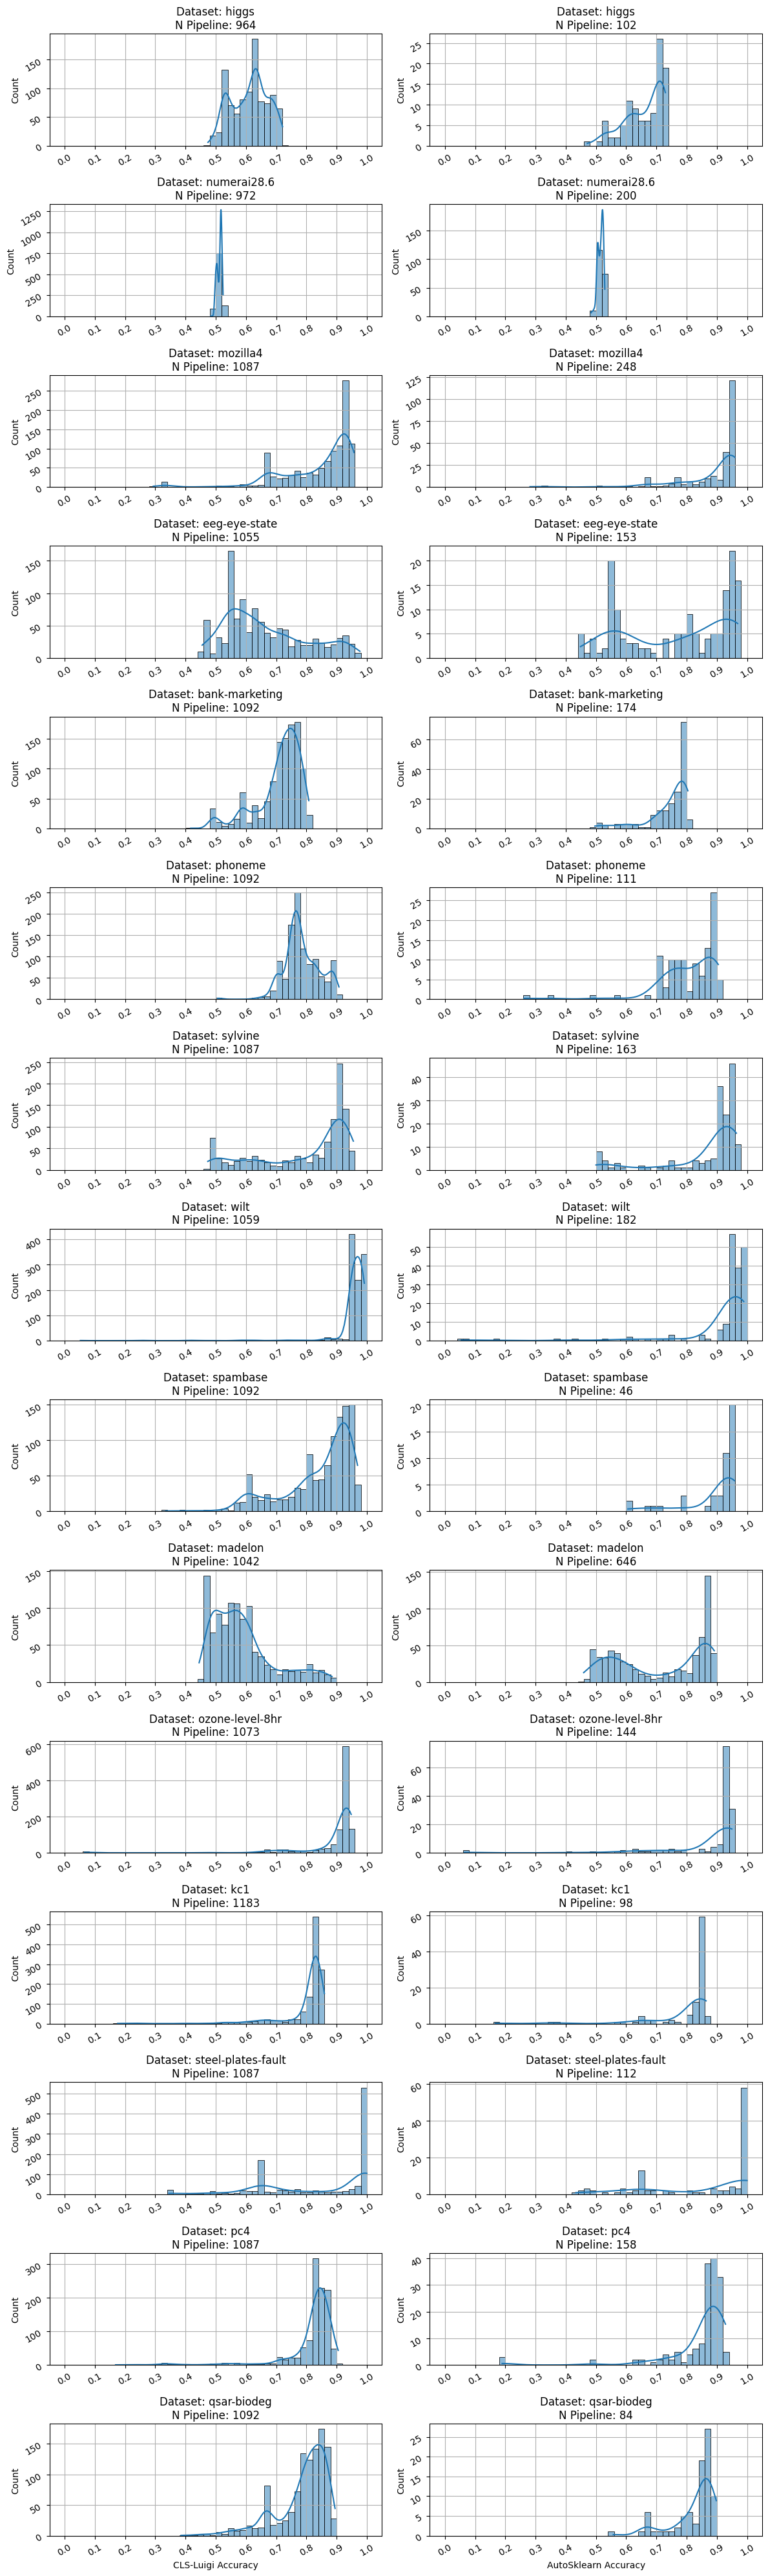

In [32]:
import matplotlib.pyplot as plt


def plot_scores_dist(datasets, figsize=(12, 40), n_cols=2):
    figure, axes = plt.subplots(nrows=len(datasets), ncols=n_cols, figsize=figsize)
    
    bins = [x / 100 for x in range(0, 102, 2)]
    
    for i, ds in enumerate(datasets):
        cls_luigi_test_scores = get_cls_luigi_test_scores(ds)
        ax_1 = sns.histplot(data=cls_luigi_test_scores, kde=True, ax=axes[i][0], bins=bins)
        
        askl_test_scores = get_askl_test_scores(ds)
        ax_2 = sns.histplot(data=askl_test_scores, kde=True, ax=axes[i][1], bins=bins)
        
        if i == len(datasets) - 1:
            ax_1.set_xlabel("CLS-Luigi Accuracy")
            ax_2.set_xlabel("AutoSklearn Accuracy")
        
        
        subplot_title = f"Dataset: {ds}"
        ax_1.set_title(subplot_title + f"\nN Pipeline: {len(cls_luigi_test_scores)}")
        ax_2.set_title(subplot_title + f"\nN Pipeline: {len(askl_test_scores)}")
        
        ax_1.grid()
        ax_2.grid()
        

        
   
    
    
    plt.setp(axes,
             xticks=[x / 100 for x in range(0, 110, 10)],
            #  yticks=range(0, 70, 10)
             
             )
    
    for ax in axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
            
    plt.tight_layout()
    
    plt.show()
    
    
    
    
plot_scores_dist(list(dataset_info.index))

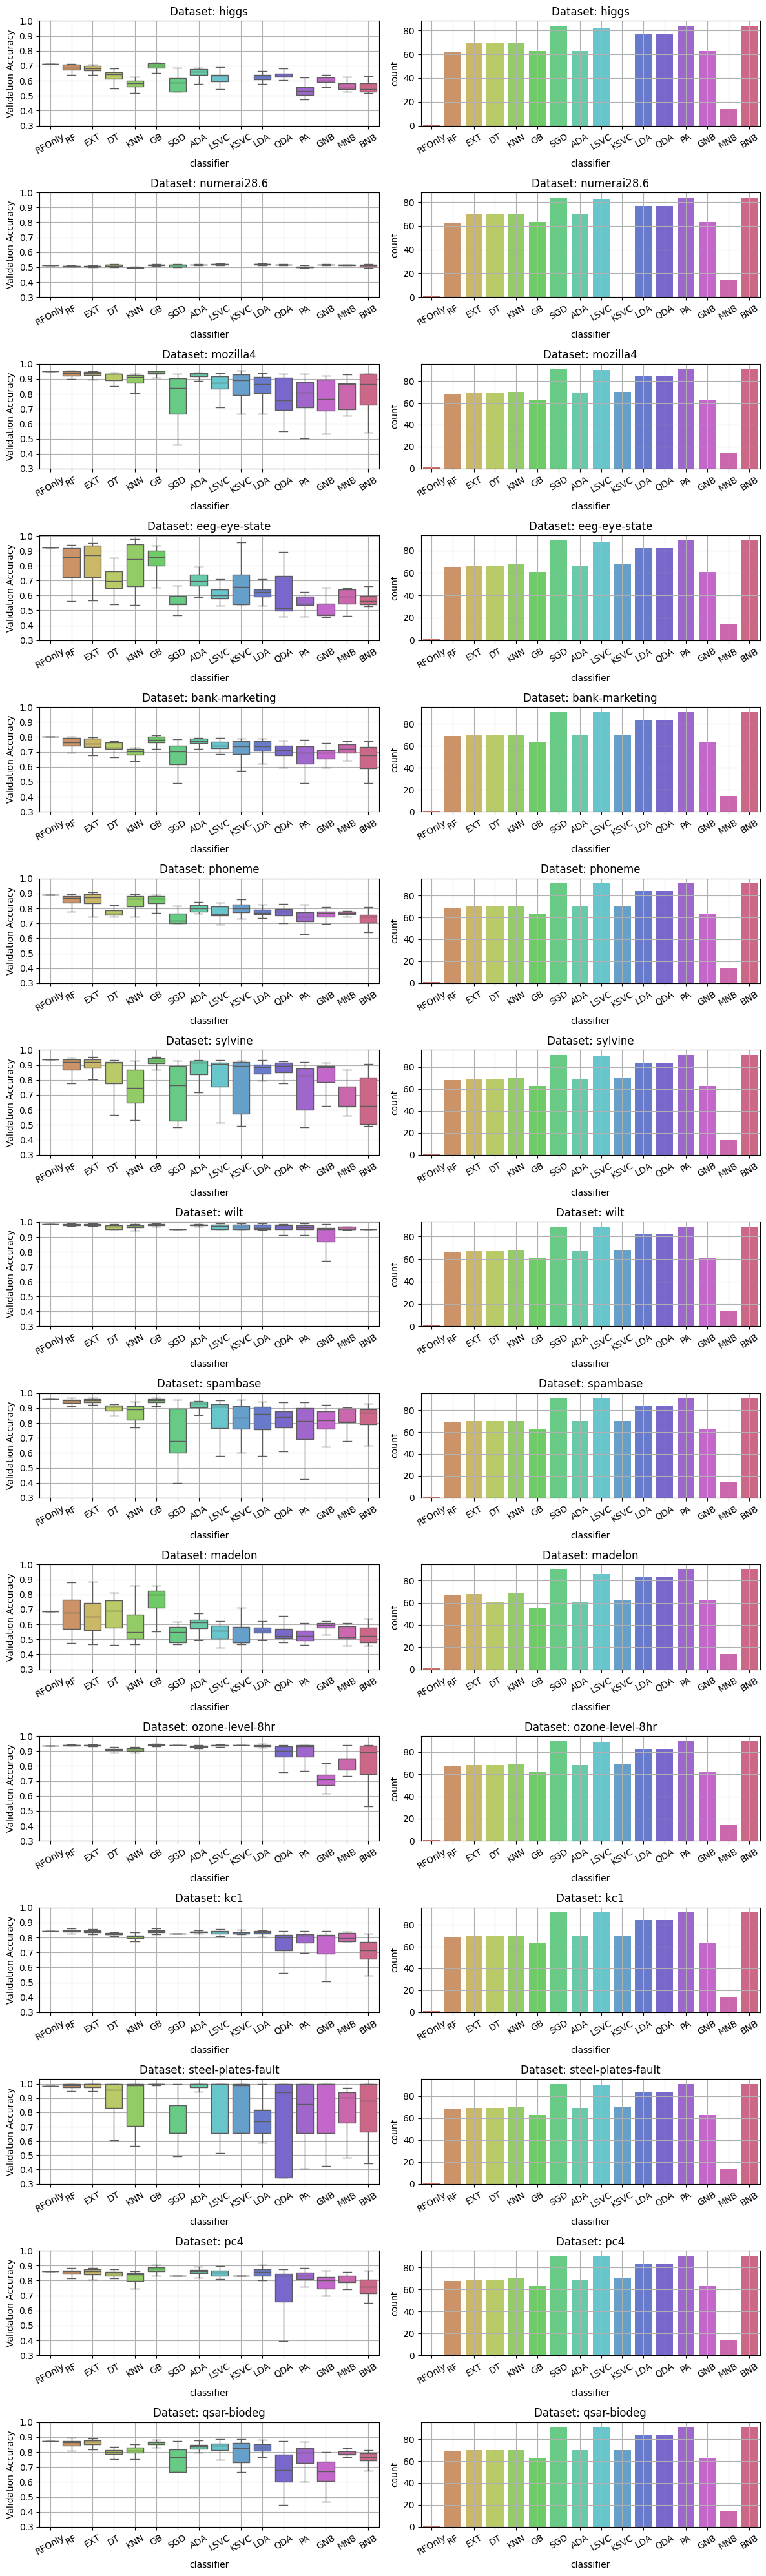

In [34]:
def plot_score_per_classifier_boxplot(datasets, figsize=(12, 40), n_cols=2):
    figure, axes = plt.subplots(nrows=len(datasets), ncols=n_cols, figsize=figsize)
    
    n_colours = len(list(clf_short_names.values()))
    c_map = {}
    for ix, v in enumerate(clf_short_names.values()):
        c_map[v] = sns.color_palette("hls", n_colours)[ix]
    
    
    
    for ix, ds in enumerate(datasets):
        rh = pd.read_csv(f"binary_classfication_pipelines/run_histories/{ds}_train_run_history.csv")
        successful = rh[rh["status"] == "success"]
        
        only_rf_index = successful[
            (successful["classifier"] == "SKLRandomForest") &
            (successful["scaler"].isna()) &
            (successful["feature_preprocessor"].isna())
        ].index
        
        successful.loc[only_rf_index, "classifier"] = "RandomForestOnly"
        
        successful["classifier"] = successful["classifier"].map(clf_short_names)
      
        ax1 = sns.boxplot(data=successful, x="classifier", y="valid_accuracy", ax=axes[ix][0], palette=c_map, order=clf_short_names.values(), showfliers = False)
        ax2 = sns.countplot(x=successful["classifier"], ax=axes[ix][1], palette=c_map, order=clf_short_names.values())
        
        ax1.set_yticks([x / 100 for x in range(30, 110, 10)])
        ax1.set_ylabel("Validation Accuracy")
        
        ax1.set_title(f"Dataset: {ds}")
        ax2.set_title(f"Dataset: {ds}")
        
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
        
        ax1.grid()
        ax2.grid()


        
    # figure.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()


plot_score_per_classifier_boxplot(dataset_info.index)

In [36]:
# def get_askl_run_info(ds):
    
#     clf, f_preproc, scaler, score, pipeline_str  = [], [], [], [], []
    
#     askl = load_pickle(pjoin("askl/results", ds, "askl_obj.pkl"))
#     cv_results = askl.cv_results_
#     test_scores = cv_results["mean_test_score"]
    
#     rh = load_json(f"/home/hadi/cls-luigi_paper/askl/results/{ds}/smac3-output/run_42/runhistory.json")
    
#     configs = rh["configs"]
    
#     for ix, s in enumerate(test_scores):
#         if s > 0.0:
#             score.append(s)
#             config = configs[str(ix + 2)]
            
#             _clf = config["classifier:__choice__"]
#             clf.append(_clf)
            
#             _f_preproc = config["feature_preprocessor:__choice__"] if config["feature_preprocessor:__choice__"] != "no_preprocessing" else None
#             f_preproc.append(_f_preproc)
            
#             _scaler = config["data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__"] if config["data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__"] != "none" else None
#             scaler.append(_scaler)
            
#             pipeline_str.append(_clf + " + " + str(_f_preproc) + " + " + str(_scaler))
            
            
            
#     df = pd.DataFrame()
#     df["clf"] = clf
#     df["f_preproc"] = f_preproc
#     df["scaler"] = scaler
#     df["accuracy"] = score
#     df["pipeline_str"] = pipeline_str
    
#     return df
    
    
    
            



In [37]:
# def plot_askl_accuracy(datasets):
#     figure, axes = plt.subplots(nrows=len(datasets), figsize=(12, 40))
    
#     for ix, ds in enumerate(datasets):
#         askl_run_info = get_askl_run_info(ds)
        
#         ax = sns.boxplot(data=askl_run_info, x="clf", y="accuracy", ax=axes[ix], showfliers=False)
        
#         ax.set_title(f"Dataset: {ds}")
#         ax.set_ylabel("Validation Accuracy")
#         ax.set_xlabel("Pipeline")
        
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
#         ax.grid()
        
#     plt.tight_layout()
#     plt.show()
    
    
# plot_askl_accuracy(dataset_info.index)